In [1]:
!pip -q install pymilvus torch gdown torchvision tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.4/222.4 kB 5.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 52.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 MB 34.6 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


# Setting up Milvus VectorDB

### Setting up global parameters

In [2]:
COLLECTION_NAME = 'image_search'  # Collection name
DIMENSION = 2048  # Embedding vector size in this example

BATCH_SIZE = 128
TOP_K = 3

In [3]:
from pymilvus import MilvusClient, DataType

In [4]:
client = MilvusClient("milvus1.db")

### Defining Schema (Formal Structure) for the `image_search` collection

In [5]:
schema = client.create_schema(
    auto_id=True,
    enable_dynamic_field=False,
)

schema.add_field(field_name="id", datatype=DataType.INT64, is_primary=True, auto_id=True)
schema.add_field(field_name="filepath", datatype=DataType.VARCHAR, max_length=200)
schema.add_field(field_name="image_embedding", datatype=DataType.FLOAT_VECTOR, dim=DIMENSION, nullable=True)

{'auto_id': True, 'description': '', 'fields': [{'name': 'id', 'description': '', 'type': <DataType.INT64: 5>, 'is_primary': True, 'auto_id': True}, {'name': 'filepath', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 200}}, {'name': 'image_embedding', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 2048}, 'nullable': True}], 'enable_dynamic_field': False}

### Creating the collection

In [6]:
if client.has_collection(collection_name=COLLECTION_NAME):
    client.drop_collection(collection_name=COLLECTION_NAME)
    
client.create_collection(
    collection_name=COLLECTION_NAME,
    schema=schema
)

### Setting Index Parameters

In [7]:
index_params = client.prepare_index_params()

##### Field Name Configuration
field_name="image_embedding" specifies that we're creating an index for a vector field named "image_embedding". This is typically used for storing dense vector representations of images after they've been processed through neural networks.

##### Index Type Selection
index_type="IVF_FLAT" implements an Inverted File Index with Flat quantization. Here's why this matters:

- It divides your vector data into clusters (called "inverted files")
- Each cluster contains similar vectors together
- During search, it only examines clusters that are likely to contain matches
- This significantly reduces the number of distance calculations needed milvus.io

##### Metric Type Choice
metric_type="L2" selects the L2 (Euclidean) distance metric for measuring similarity between vectors. This is particularly well-suited for image embeddings because:

- It measures the straight-line distance between two points in n-dimensional space
- It's sensitive to both direction and magnitude differences
- It's widely used in computer vision applications
- It provides intuitive, interpretable results milvus.io

##### Parameter Optimization
params={"nlist": 16384} configures the fundamental parameter of IVF_FLAT indexing:

- nlist determines the number of cluster centers (16384 in this case)
- Higher values lead to:
    - More precise clustering
    - Better search accuracy
    - Increased memory usage
    - Slower indexing speed

In [8]:
index_params.add_index(
    field_name="image_embedding",
    index_type="IVF_FLAT", # Inverted File Index with Flat quantization
    metric_type= "L2", # Define your desired similarity search method (L2 is Euclidean)
    params= {"nlist": 16384}
)

In [9]:
client.create_index(
    collection_name=COLLECTION_NAME,
    index_params=index_params
)

In [10]:
client.load_collection(collection_name=COLLECTION_NAME)

#  Importing Embedding Model 

### Loading RESNET50 for generating image embeddings

In [11]:
import torch

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 347MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


### Defining the Data Augmentation Pipeline

In [12]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Inserting Image Embeddings into VectorDB

### Grabbing the data

In [13]:
import gdown
import zipfile

url = 'https://drive.google.com/uc?id=1OYDHLEy992qu5C4C8HV5uDIkOWRTAR1_'
output = './paintings.zip'
gdown.download(url, output)

with zipfile.ZipFile("./paintings.zip","r") as zip_ref:
    zip_ref.extractall("./paintings")


Downloading...
From (original): https://drive.google.com/uc?id=1OYDHLEy992qu5C4C8HV5uDIkOWRTAR1_
From (redirected): https://drive.google.com/uc?id=1OYDHLEy992qu5C4C8HV5uDIkOWRTAR1_&confirm=t&uuid=aac26225-dbb7-4eba-abe5-44b34c651115
To: /kaggle/working/paintings.zip
100%|██████████| 2.35G/2.35G [00:22<00:00, 103MB/s] 


### Getting Search Paths

In [14]:
import glob

paths = glob.glob('./paintings/paintings/**/*.jpg', recursive=True)
len(paths)

4978

### Generating Image Embeddings and Inserting them into the VectorDB

In [15]:
from PIL import Image
from tqdm import tqdm

# Embed function that embeds the batch and inserts it
def embed(data):
    with torch.no_grad():
        output = model(torch.stack(data[0])).squeeze()
        
        embd_data = output.tolist() if output is not None else [0.0] * DIMENSION
        
        data = [
                {"filepath": data[1][i], "image_embedding": embd_data[i]} for i in range(BATCH_SIZE)
            ]
        
        client.insert(
                collection_name=COLLECTION_NAME,
                data=data
            )

In [16]:
data_batch = [[],[]]

# Read the images into batches for embedding and insertion
for path in tqdm(paths):
    im = Image.open(path).convert('RGB')
    data_batch[0].append(preprocess(im))
    data_batch[1].append(path)
    if len(data_batch[0]) % BATCH_SIZE == 0:
        embed(data_batch)
        data_batch = [[],[]]


100%|██████████| 4978/4978 [17:42<00:00,  4.68it/s]  


In [17]:
# # Embed and insert the remainder
# if len(data_batch[0]) != 0:
#     embed(data_batch)

# Test Case

### Getting Search Paths

In [18]:
import glob

# Get the filepaths of the search images
search_paths = glob.glob('./paintings/test_paintings/**/*.jpg', recursive=True)
len(search_paths)

2

### Generating Image Embeddings for the test cases

In [33]:
import time
from matplotlib import pyplot as plt

def test_embed(data):
    with torch.no_grad():
        ret = model(torch.stack(data))
        # If more than one image, use squeeze
        if len(ret) > 1:
            return ret.squeeze().tolist()
        # Squeeze would remove batch for single image, so using flatten
        else:
            return torch.flatten(ret, start_dim=1).tolist()

In [34]:
data_batch = [[],[]]

for path in search_paths:
    im = Image.open(path).convert('RGB')
    data_batch[0].append(preprocess(im))
    data_batch[1].append(path)

### Searching Images using L2 Metric

In [35]:
embeds = test_embed(data_batch[0])
start = time.time()
# res = client.search(embeds, anns_field='image_embedding', param={'nprobe': 128}, limit=TOP_K, output_fields=['filepath'])
res = client.search(
    collection_name=COLLECTION_NAME,  # target collection
    anns_field='image_embedding',
    data=embeds,  # query vectors
    # param={'nprobe': 128},
    limit=TOP_K,  # number of returned entities
    output_fields=["filepath"],
    # search_params={"metric_type": "IP"}

)
finish = time.time()

In [36]:
data_batch[1]

['./paintings/test_paintings/9451215538_1853714512_h.jpg',
 './paintings/test_paintings/44777133331_8c033371cd_k.jpg']

# Plotting Images

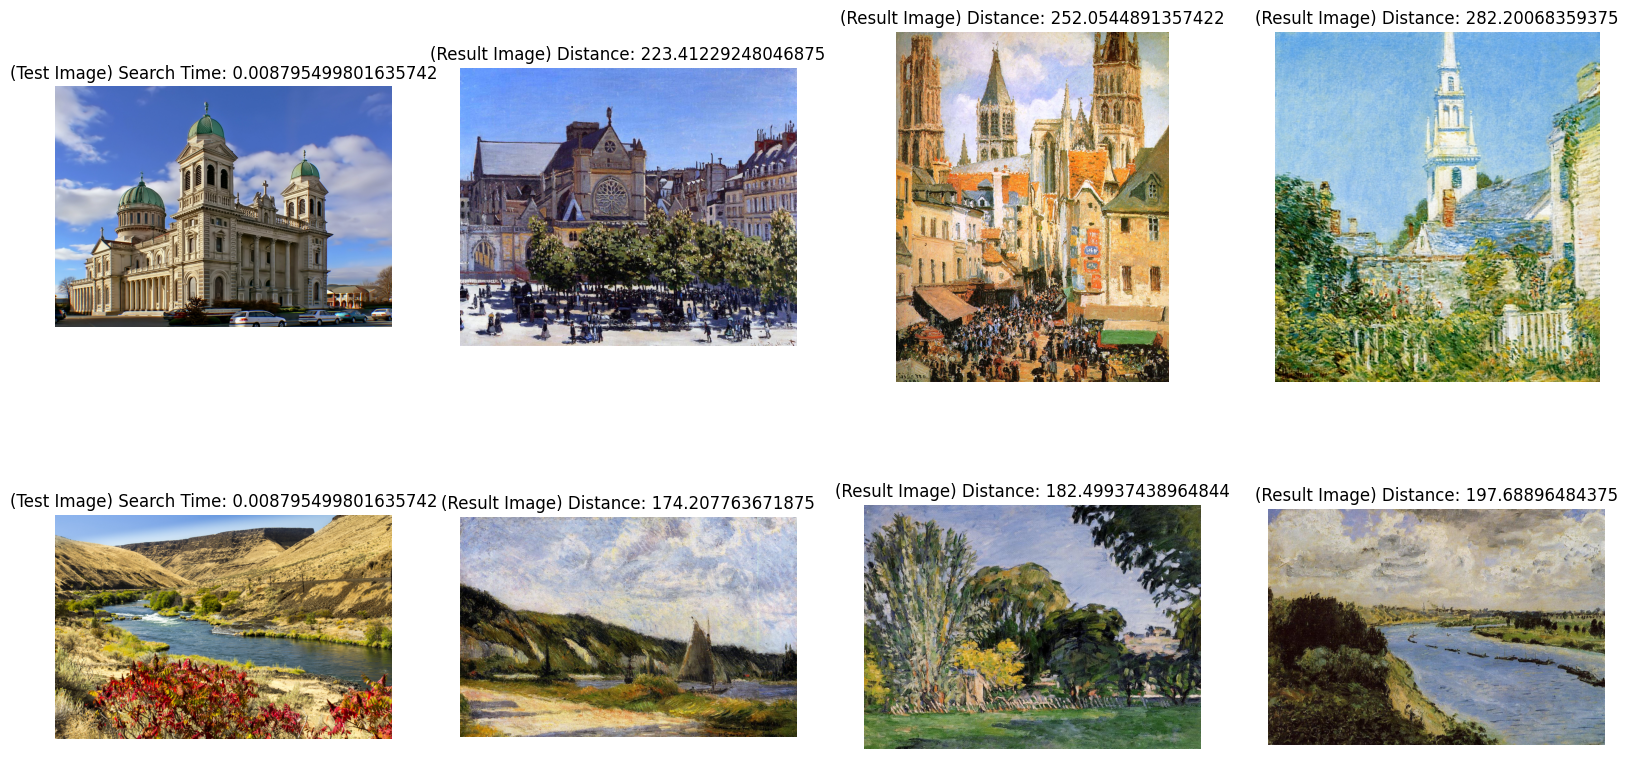

In [37]:
# Show the image results
f, axarr = plt.subplots(len(data_batch[1]), TOP_K + 1, figsize=(20, 10), squeeze=False)

for hits_i, hits in enumerate(res):
    axarr[hits_i][0].imshow(Image.open(data_batch[1][hits_i]))
    axarr[hits_i][0].set_axis_off()
    axarr[hits_i][0].set_title('(Test Image) Search Time: ' + str(finish - start))
    for hit_i, hit in enumerate(hits):
        axarr[hits_i][hit_i + 1].imshow(Image.open(hit['entity'].get('filepath')))
        axarr[hits_i][hit_i + 1].set_axis_off()
        axarr[hits_i][hit_i + 1].set_title('(Result Image) Distance: ' + str(hit['distance']))

# Save the search result in a separate image file alongside your script.
plt.savefig('search_result.png')

# Searching using a random tensor

In [49]:
data = torch.rand(size = [5, 
]).tolist()

In [50]:
start = time.time()
# res = client.search(embeds, anns_field='image_embedding', param={'nprobe': 128}, limit=TOP_K, output_fields=['filepath'])
res = client.search(
    collection_name=COLLECTION_NAME,  # target collection
    anns_field='image_embedding',
    data=data,  # query vectors
    # param={'nprobe': 128},
    limit=TOP_K,  # number of returned entities
    output_fields=["filepath"],
    # search_params={"metric_type": "IP"}

)
finish = time.time()

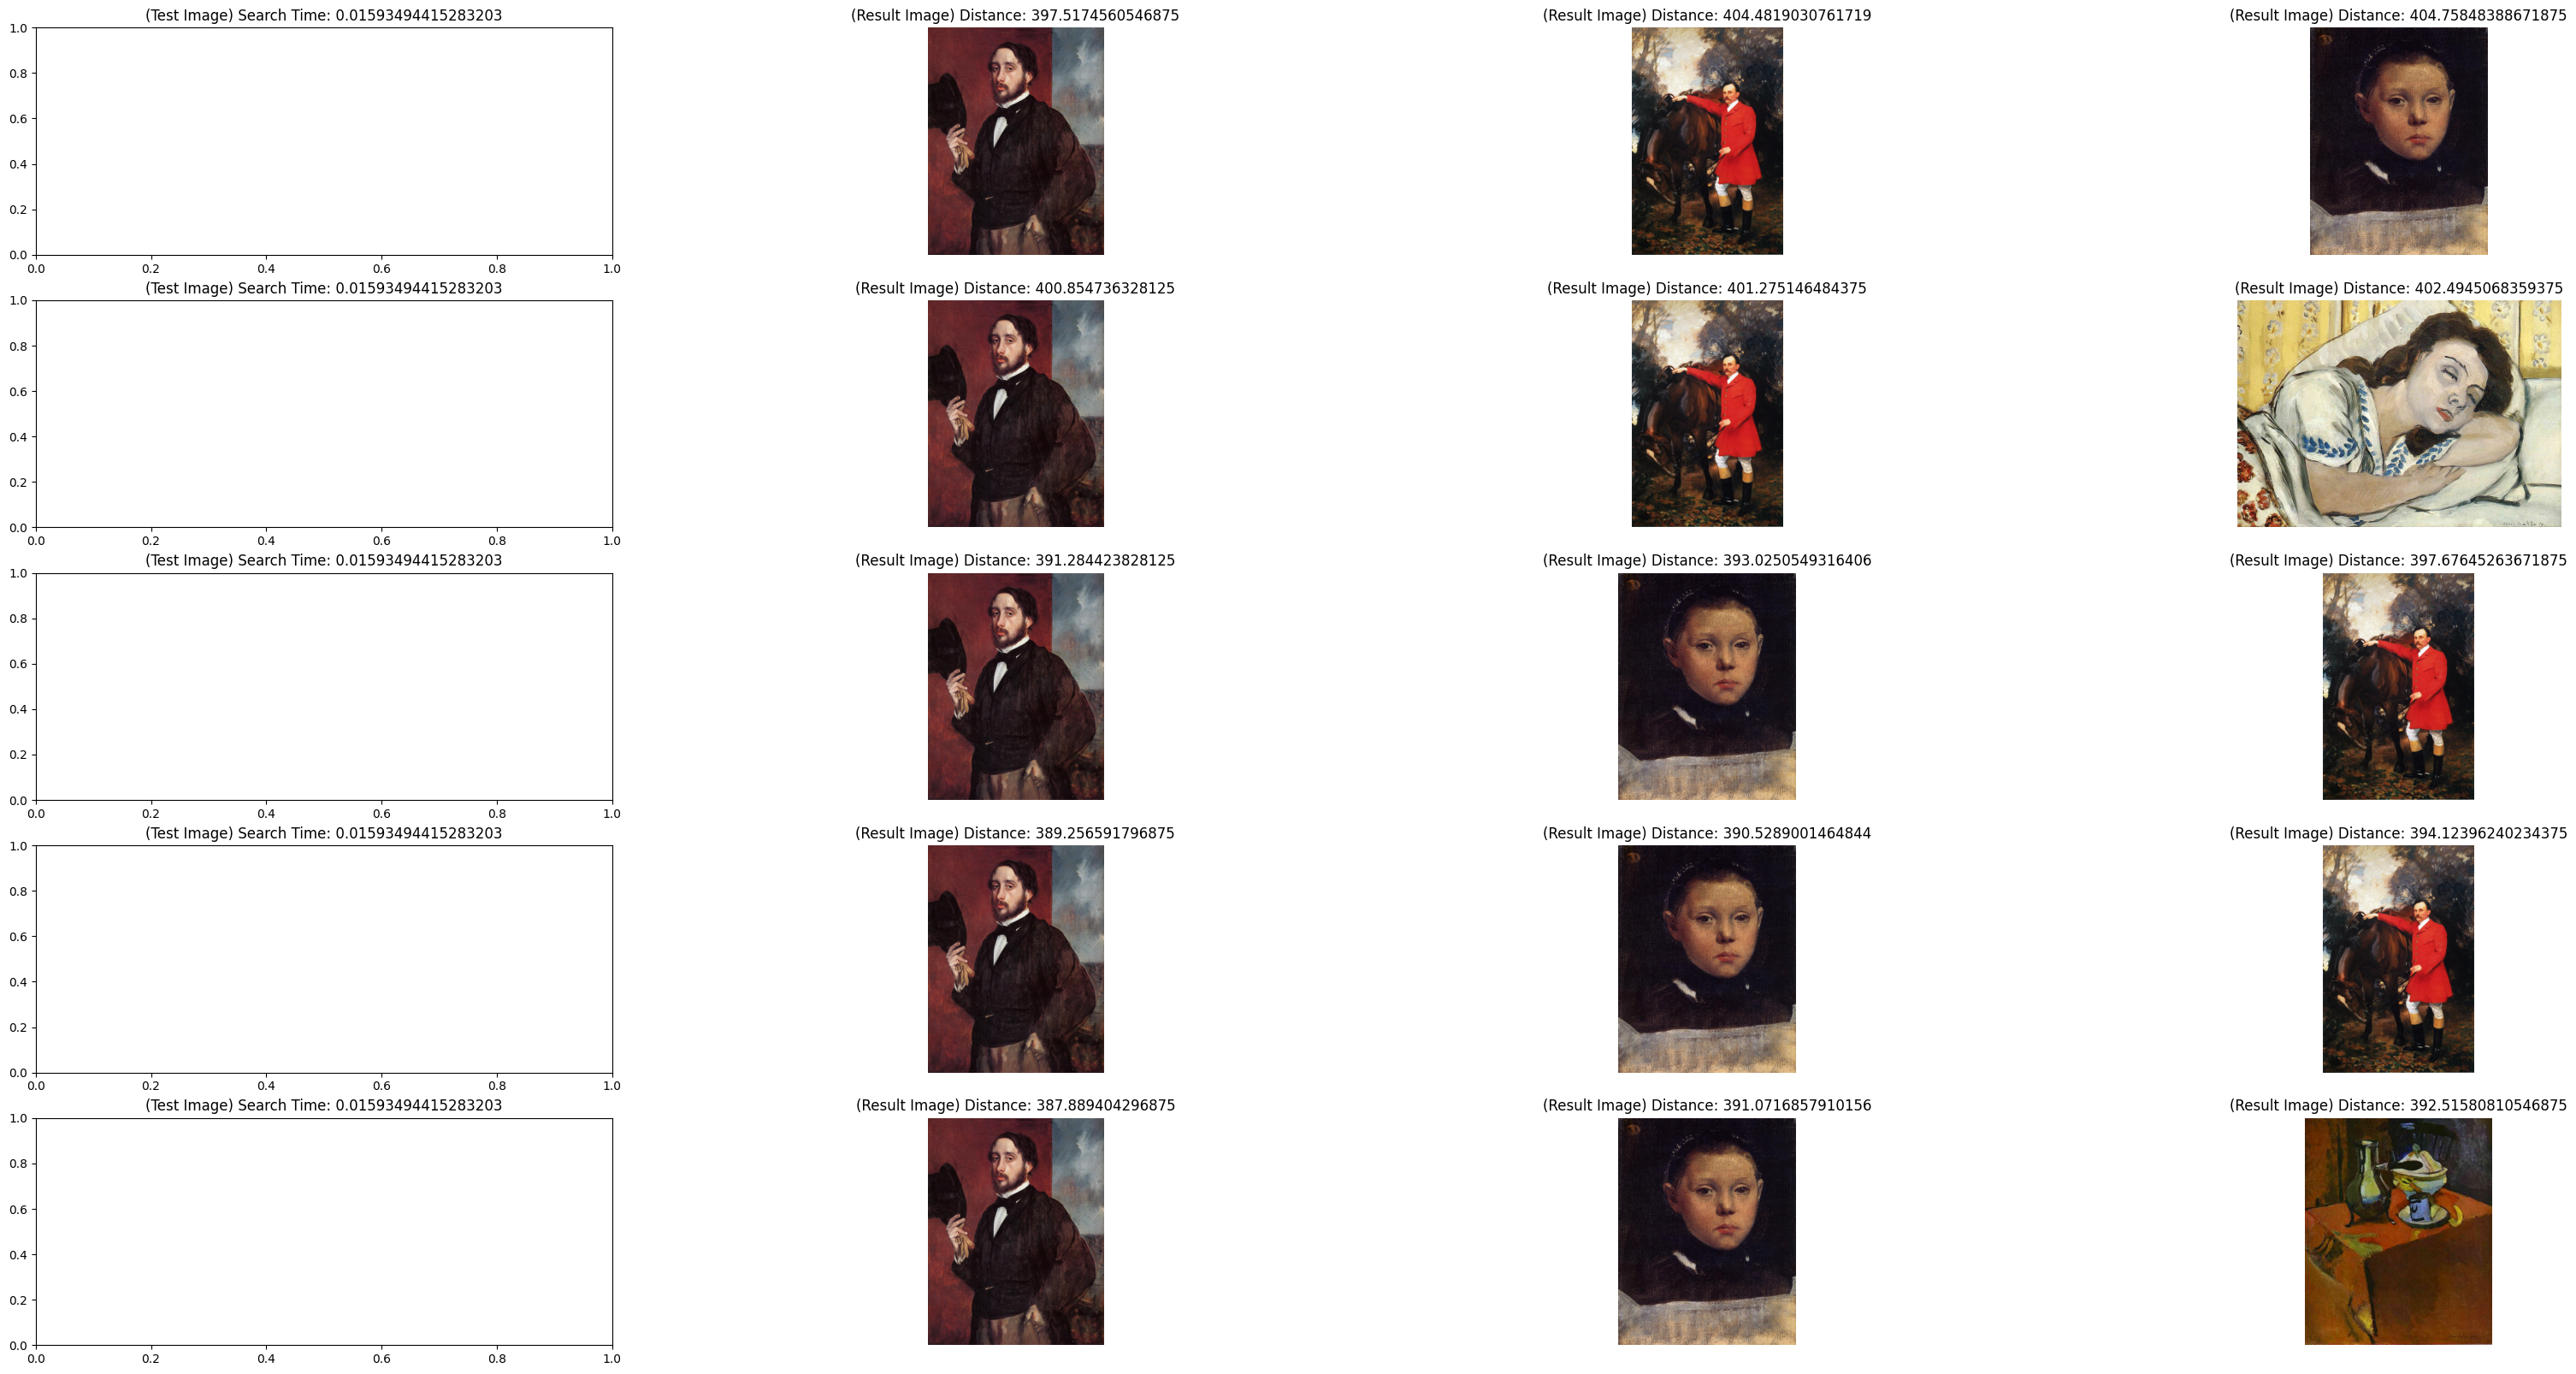

In [53]:
# Show the image results
f, axarr = plt.subplots(len(data), TOP_K + 1, figsize=(40, 20), squeeze=False)

for hits_i, hits in enumerate(res):
    # axarr[hits_i][0].imshow(Image.open(data[hits_i]))
    # axarr[hits_i][0].set_axis_off()
    axarr[hits_i][0].set_title('(Test Image) Search Time: ' + str(finish - start))
    for hit_i, hit in enumerate(hits):
        axarr[hits_i][hit_i + 1].imshow(Image.open(hit['entity'].get('filepath')))
        axarr[hits_i][hit_i + 1].set_axis_off()
        axarr[hits_i][hit_i + 1].set_title('(Result Image) Distance: ' + str(hit['distance']))

# Save the search result in a separate image file alongside your script.
plt.savefig('random_search_result.png')